# Data Exploration

In [1]:
# Packages
import numpy as np
import pandas as pd
from zipfile import ZipFile

In [2]:
import matplotlib.pyplot as plt

In [3]:
! pip install fastprogress
from fastprogress import master_bar, progress_bar

## Loading data
Data available at link: https://www.kaggle.com/CooperUnion/anime-recommendations-database

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
PATH_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/graph_based_recommendation_system'
%cd {PATH_FOLDER}

/content/gdrive/.shortcut-targets-by-id/1Qu7UOLxDtaHg6JbrDo0q-3e4ePr807CH/graph_based_recommendation_system


In [6]:
%ls

DataExploration.ipynb  figures/                project_proposal.docx  README.md
dataset.zip            graph_features.adjlist  project_proposal.pdf


In [7]:
# Loading dataset from .zip file
path_dataset = "dataset.zip"

with ZipFile(path_dataset, 'r') as zip_ref:
    all_path = zip_ref.namelist()
    print('Paths: ', all_path)
    
    df_anime = pd.read_csv(zip_ref.open(all_path[0]))
    df_rating = pd.read_csv(zip_ref.open(all_path[1]))

Paths:  ['anime.csv', 'rating.csv']


### Anime

In [8]:
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


### Rating

In [9]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Basic statistics

In [10]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items

print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  84715
Number of edges:  7813737


## Pre-processing

Elimination of rows that have Nan values

In [11]:
#df_anime.dropna(inplace=True)
df_rating.dropna(inplace=True)

Elimination of all rating values whose anime doesn't have a description in file 'anime.csv'

In [12]:
for i in df_rating.anime_id.unique():
  if df_anime[df_anime['anime_id'] == i].empty:
    df_rating = df_rating[df_rating['anime_id'] != i]

Elimination of all user-item iteraction when a rate has not been given (rating = -1)

In [13]:
# number of user that have seen an anime, but didn't give a rate (meaning rating = -1)
df_rating[df_rating['rating'] == -1].rating.value_counts()

-1    1476488
Name: rating, dtype: int64

In [14]:
# new dataframe without user-item itercations with rating = -1
new_df_rating = df_rating[df_rating['rating'] != -1]
assert(new_df_rating.shape[0] == df_rating.shape[0] - 1476488)

df_rating = new_df_rating
del new_df_rating

Number of possible nodes and edges after the pre-processing phase

In [15]:
num_users = len(df_rating['user_id'].unique())
num_items = len(df_rating['anime_id'].unique())
num_nodes = num_users + num_items

print('Number of nodes: ', num_nodes)
print('Number of edges: ', df_rating.shape[0])

Number of nodes:  79526
Number of edges:  6337239


## Anime by genre

In [16]:
def search_gerne(df_iteractions, df_description, feature, verbose=0):
    '''
    Function to search all items that have 'feature' in one column of dataframe
    df_description (column 'gerne' in this case) and search all corresponding 
    iteractions on df_iteractions
    -------------
    Return:
      Dataframe df_result             All iteractions whose item has feature
    '''
    
    # Creation of a item list with gerne = feature
    item_list = [] # anime_list
    for i in range(df_description.shape[0]):
      _ = str(df_description.iloc[i,2])
      if _ != 'nan':
        if feature in _:
            item_list.append(df_description.iloc[i,0])
            
    if verbose: print('Number of Items - {}: {}'.format(feature, len(item_list)))
    
    
    
    # Search anime found before in df_iteractions
    iteraction_list = []
    for i in item_list:
        _ = df_iteractions[df_iteractions['anime_id'] == i].index
        iteraction_list.extend(_)
        
    if verbose: print('Number of Iteractions - {}: {}'.format(feature, len(iteraction_list)))
    
    return df_iteractions.loc[iteraction_list, :]

In [17]:
# Creation of a list for all anime genres
gerne_list = []

for i in progress_bar(range(df_anime.shape[0])):
  _ = str(df_anime.iloc[i,2])
  if _ != 'nan':
    _ = df_anime.iloc[i,2].split(', ')
    gerne_list.extend(_)

gerne_list = list(set(gerne_list))

print('Number of genres: ', len(gerne_list))
print('Genres:\n', gerne_list)

Number of genres:  43
Genres:
 ['Cars', 'Super Power', 'Harem', 'Supernatural', 'Kids', 'Psychological', 'Shounen', 'Yuri', 'Sports', 'Fantasy', 'Romance', 'Dementia', 'Shoujo', 'Space', 'Slice of Life', 'Comedy', 'Music', 'Yaoi', 'Martial Arts', 'Vampire', 'Josei', 'School', 'Historical', 'Parody', 'Samurai', 'Shounen Ai', 'Adventure', 'Military', 'Horror', 'Police', 'Hentai', 'Game', 'Seinen', 'Ecchi', 'Thriller', 'Drama', 'Mecha', 'Action', 'Mystery', 'Demons', 'Shoujo Ai', 'Sci-Fi', 'Magic']


In [18]:
# Count how much intercations we have on df_rating given a genre
gerne_counts = []
for g in progress_bar(gerne_list):
  _ = search_gerne(df_rating, df_anime, g)
  gerne_counts.append(_.shape[0])

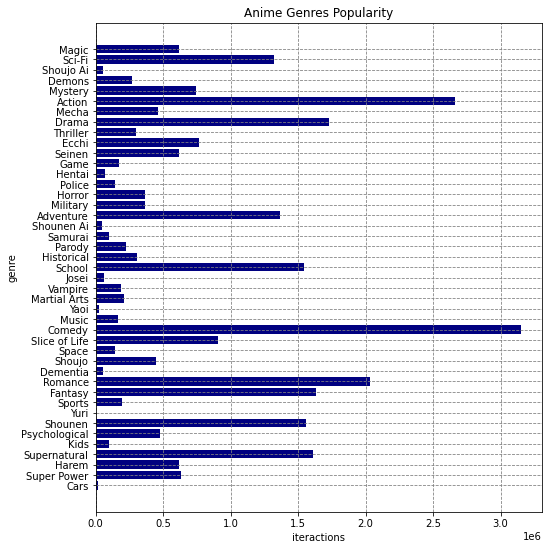

In [19]:
fig, ax = plt.subplots(figsize=(8,9))

ax.barh(np.arange(len(gerne_list)), gerne_counts, color='navy')

ax.set_yticks(np.arange(len(gerne_list)))
ax.set_yticklabels(gerne_list)
ax.set_title('Anime Genres Popularity')
ax.set_xlabel('iteractions')
ax.set_ylabel('genre')
plt.grid(color='grey', linestyle='--')

plt.savefig('./figures/anime_genres_popularity.jpg')

plt.show()

# Graph Creation

In [20]:
import networkx as nx
G = nx.Graph()

In [21]:
# Add user nodes
for i in progress_bar(df_rating.user_id.unique()):
  G.add_nodes_from([
    ('user_' + str(i), {'node_type':'user'})
  ])

In [22]:
# Add anime nodes
for i in progress_bar(df_rating.anime_id.unique()):
  name = df_anime[df_anime['anime_id']==i].name.to_string(index=False)[1:]
  genre = df_anime[df_anime['anime_id']==i].genre.to_string(index=False)[1:].split(', ')
  anime_type = df_anime[df_anime['anime_id']==i]['type'].to_string(index=False)[1:]
  episodes = str(df_anime[df_anime['anime_id']==i].episodes.to_string(index=False)[1:]) # because there is also value 'unknown'

  rating = df_anime[df_anime['anime_id']==i].rating.to_string(index=False)
  if rating != 'NaN':
    rating = float(rating[1:])
  else:
    rating = 0.0

  members = int(df_anime[df_anime['anime_id']==i].members.to_string(index=False)[1:])
  

  G.add_nodes_from([
    ('anime_' + str(i), {'node_type':'anime',
                         'name':name,
                         'genre':genre,
                         'type':anime_type,
                         'episodes':episodes,
                         'rating':rating,
                         'members':members})
  ])

In [23]:
# Add user-item iteractions -> Edges
for i in progress_bar(range(df_rating.shape[0])):
  user = 'user_' + str(df_rating.iloc[i,0])
  anime = 'anime_' + str(df_rating.iloc[i,1])
  rating = df_rating.iloc[i,2]

  G.add_edges_from([(user, anime, {'weight':rating})])

**Save graph**:

In [24]:
nx.readwrite.adjlist.write_adjlist(G, './graph_features.adjlist')

Check if it works

In [25]:
_ = nx.readwrite.adjlist.read_adjlist('./graph_features.adjlist')

Plot of a sample of k random nodes

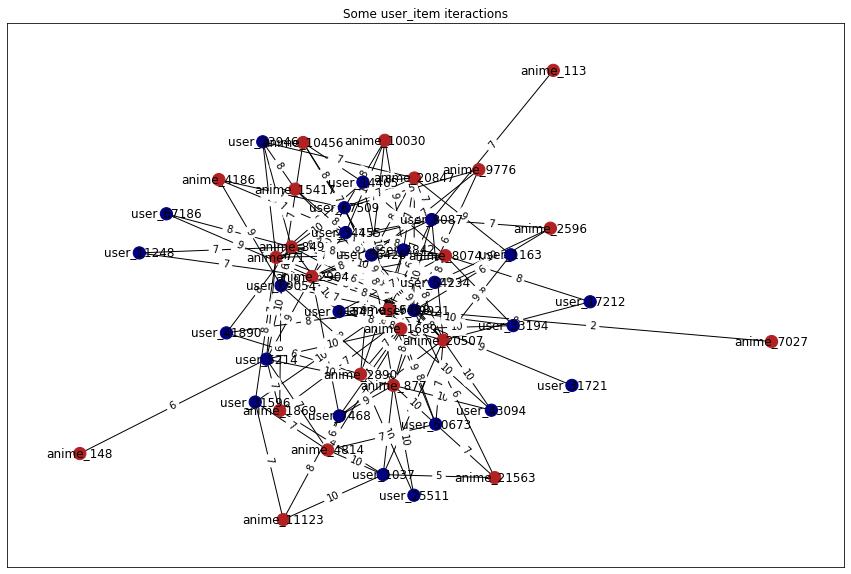

In [26]:
# ----------------- Creation of a subgraph ---------------------
import random
random.seed = 1
k = 25
ids = random.choices(range(df_rating.shape[0]), k=k)
nodes = []
_ = ['user_'+str(id) for id in df_rating.iloc[ids, :].user_id.unique().tolist()]
num_users = len(_)
nodes.extend(_)
_ = ['anime_'+str(id) for id in df_rating.iloc[ids, :].anime_id.unique().tolist()]
num_items = len(_)
nodes.extend(_)

subG = G.subgraph(nodes)

# ----------------- Plot ----------------------------------------
fig, ax = plt.subplots(figsize=(15,10))

colors = ['navy' if t == 'user' else 'firebrick' for t in nx.get_node_attributes(subG,'node_type').values()]
pos=nx.spring_layout(subG, seed=1)
nx.drawing.nx_pylab.draw_networkx(subG,pos, node_color=colors, node_size=150)

labels = nx.get_edge_attributes(subG,'weight')
nx.draw_networkx_edge_labels(subG,pos,edge_labels=labels)
ax.set_title('Some user_item iteractions')
plt.savefig('./figures/graph_example.jpg')